# Figures for d)

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.logistic_regression import log_loss_ridge, import_breast_cancer, accuracy_func, logistic_loss_func, logistic_grad, ridge_term, true_pos_variable_func, false_pos_variable_func
from Code.utilities import train_test_split, plot_test_results
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam, SGD, GD
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from Code.project1_tools import scale_feature_matrix

import jax.numpy as jnp
import numpy as np
from jax import nn, grad, jit, pmap



In [2]:
X, y = import_breast_cancer()
X, means, var = scale_feature_matrix(X)
X = jnp.array(X)
y = jnp.array(y)
print(jnp.count_nonzero(y))
print(y.shape)


239
(683,)


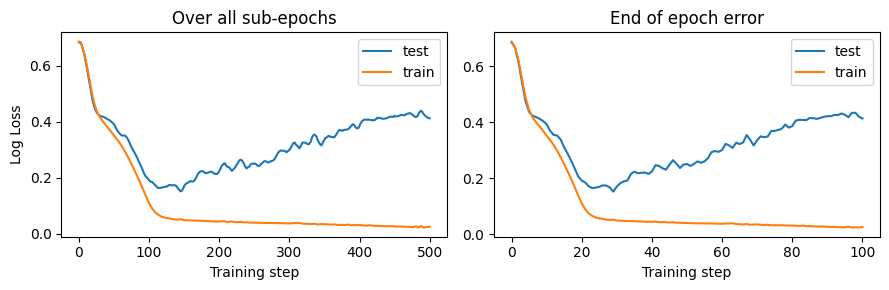

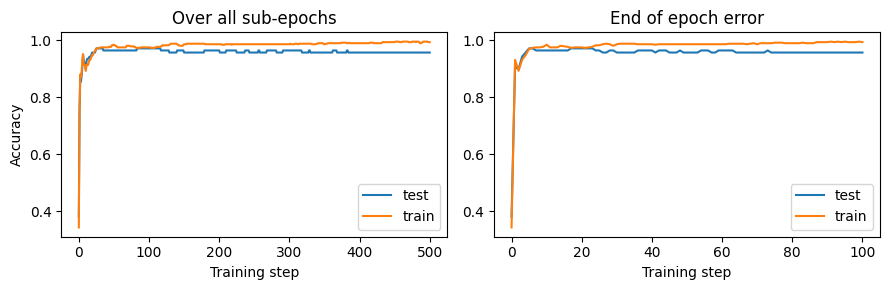

Log run


In [3]:
def single_run(X, y, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, test_index=None, plot_or_not=False):
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [1]
    beta0 = _beta_init(layer_list)

    epochs = 100

    model = jit(get_neural_network_model(hidden_layer_num ,activation=hidden_activation, output_activation=nn.sigmoid))

    loss_func = jit(logistic_loss_func(model=model))
    loss_grad = jit(grad(log_loss_ridge(model=model, lam=lam)))

    #print(loss_grad(beta0, X, y))


    acc_func = jit(accuracy_func(model))

    X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=test_index)

    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=[loss_func, acc_func], lr=lr)
    #result = SGD(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)

    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"][0], result["train_loss_list"][0], 5, ylabel="Log Loss")
        plot_test_results(result["test_loss_list"][1], result["train_loss_list"][1], 5, ylabel="Accuracy")


    return result





result = single_run(X, y, 8e-3, 0.000, hidden_layer_num=5, node_per_hidden=5, hidden_activation=nn.relu, plot_or_not=True)
print("Log run")
#result = single_run(X, y, 0.01, 0.001, 0, 5, hidden_activation=nn.relu)


### Note for report

When initializing the parameters with only positive values we get a tendency that the initial output gets bigger and bigger the larger the model. This caused the model to predict 1 in all training examples(after sigmoid) and so the gradient became zero everywhere and the model got stuck. When initializing with negative and positive values we got more varied outputs and nonzero gradients and so the model managed to start learning.


When running the model with a very low learning rate we see that the model is slowly decreasing in the loss function used to optimize, but sometimes the accuracy remains constant. This is because the model have not changed enough to push any examples over the threshold. We often see different periods in the training where the model learns very slowly at periods and then suddenly starts learning and decreases in loss quickly. In these paradigm shifts we often see a sharp increase in the accuracy of the model often going from constant accuracy to start increasing and then slows down again and stagnates.

In [4]:
activation_funcs = {"ReLu":nn.relu, "Leaky ReLu":nn.leaky_relu, "Sigmoid":nn.sigmoid, "Tanh":nn.tanh}

### Lambda Search

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

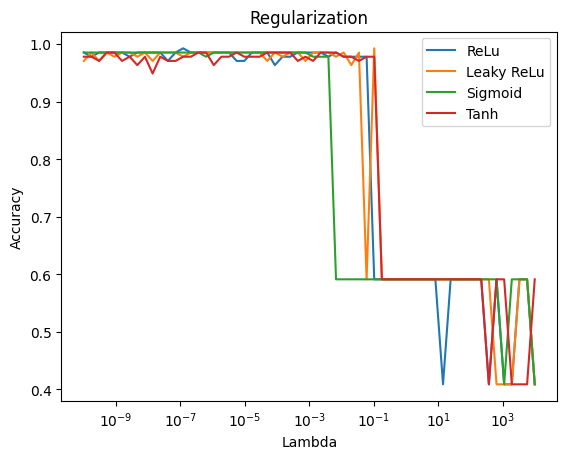

In [5]:
def search_lam(plot_or_not=False):
    lams = np.logspace(-10, 4, num=60)
    test_errs_all = {}
    train_errs_all = {}
    result = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lam in tqdm(lams):
            #tqdm.write(f"Lambda: {lam}")
            result = single_run(X, y, lr=0.01, lam=lam, hidden_layer_num=3, node_per_hidden=5, hidden_activation=activation_funcs[act_func], test_index=result.get("test_index"))
            test_errs.append(result["test_loss_list"][1][-1])
            train_errs.append(result["train_loss_list"][1][-1])
        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lams, test_errs, label=act_func)

    plt.legend()
    #plt.plot(lams, train_errs)
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Lambda")
    plt.xscale("log")
    plt.show()

    return {"lams":lams, "test_error":test_errs, "train_error":train_errs}

experiment = search_lam()

### Learning Rate search

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

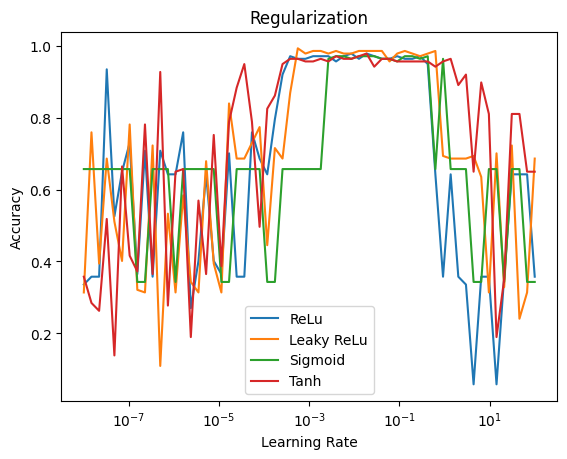

In [6]:

def search_lrs(plot_or_not=False):
    lrs = np.logspace(-8, 2, num=60)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        acc_test_errs = []
        acc_train_errs = []
        result = {}
        for lr in tqdm(lrs):
            #tqdm.write(f"Learning rate: {lr}")
            result = single_run(X, y, lr=lr, lam=0.00, hidden_layer_num=3, node_per_hidden=5, hidden_activation=activation_funcs[act_func], test_index=result.get("test_index"))
            acc_test_errs.append(result["test_loss_list"][1][-1])
            acc_train_errs.append(result["train_loss_list"][1][-1])

        test_errs_all[act_func] = acc_test_errs
        train_errs_all[act_func] = acc_train_errs

        plt.plot(lrs, acc_test_errs, label=act_func)


    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Learning Rate")
    plt.xscale("log")
    plt.show()

    return {"lrs":lrs, "test_error":test_errs_all, "train_error":train_errs_all}


#learning_rate_exp = search_lrs()
l = search_lrs()

### Note for report

The place with learning rate lower than e-4 is the place where the model sometimes has low enough initial gradients that when multiplied with the learning rate is rounded to zero and so the model becomes stuck and does not learn. Hence we see bad performance and alot of random variance in the results in this region.

### Layer Size

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

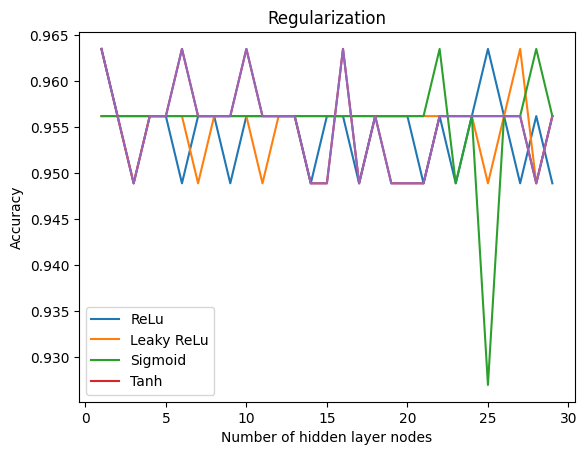

In [7]:

def search_hidden_layer_sizes(plot_or_not=False):
    hidden_layer_sizes = np.arange(1, 30)

    test_errs_all = {}
    train_errs_all = {}
    result = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_size in tqdm(hidden_layer_sizes):
            #tqdm.write(f"Hidden Layer size: {hidden_layer_size}")
            result = single_run(X, y, lr=0.01, lam=0.01, hidden_layer_num=1, node_per_hidden=hidden_layer_size, hidden_activation=activation_funcs[act_func], test_index=result.get("test_index"))
            test_errs.append(result["test_loss_list"][1][-1])
            train_errs.append(result["train_loss_list"][1][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_sizes, test_errs, label=act_func)

    plt.plot(hidden_layer_sizes, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of hidden layer nodes")
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_sizes, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_sizes()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

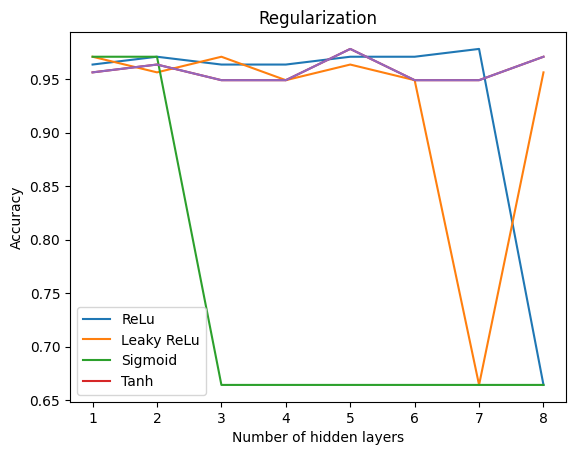

In [8]:

def search_hidden_layer_number(plot_or_not=False):
    hidden_layer_numbers = np.arange(1, 9)

    test_errs_all = {}
    train_errs_all = {}
    result = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_number in tqdm(hidden_layer_numbers):
            #tqdm.write(f"Hidden Layer number: {hidden_layer_number}")
            result = single_run(X, y, lr=0.01, lam=0.01, hidden_layer_num=hidden_layer_number, node_per_hidden=5, hidden_activation=activation_funcs[act_func], test_index=result.get("test_index"))
            test_errs.append(result["test_loss_list"][1][-1])
            train_errs.append(result["train_loss_list"][1][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_numbers, test_errs, label=act_func)

    plt.plot(hidden_layer_numbers, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of hidden layers")
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_number()

# Vary epochs maybe to show that the larger networks take longer

### ROC Curve

C:\Users\Eirik\AppData\Local\Temp\ipykernel_33284\1206709106.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_roc.show()
C:\Users\Eirik\AppData\Local\Temp\ipykernel_33284\1206709106.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cm.show()


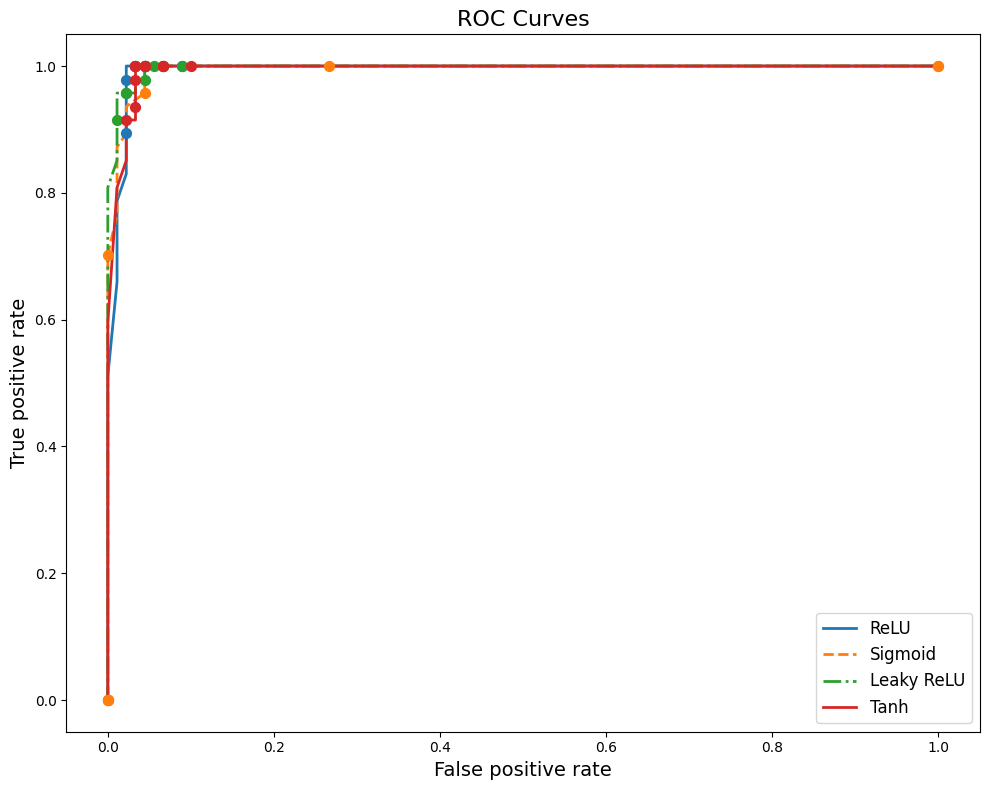

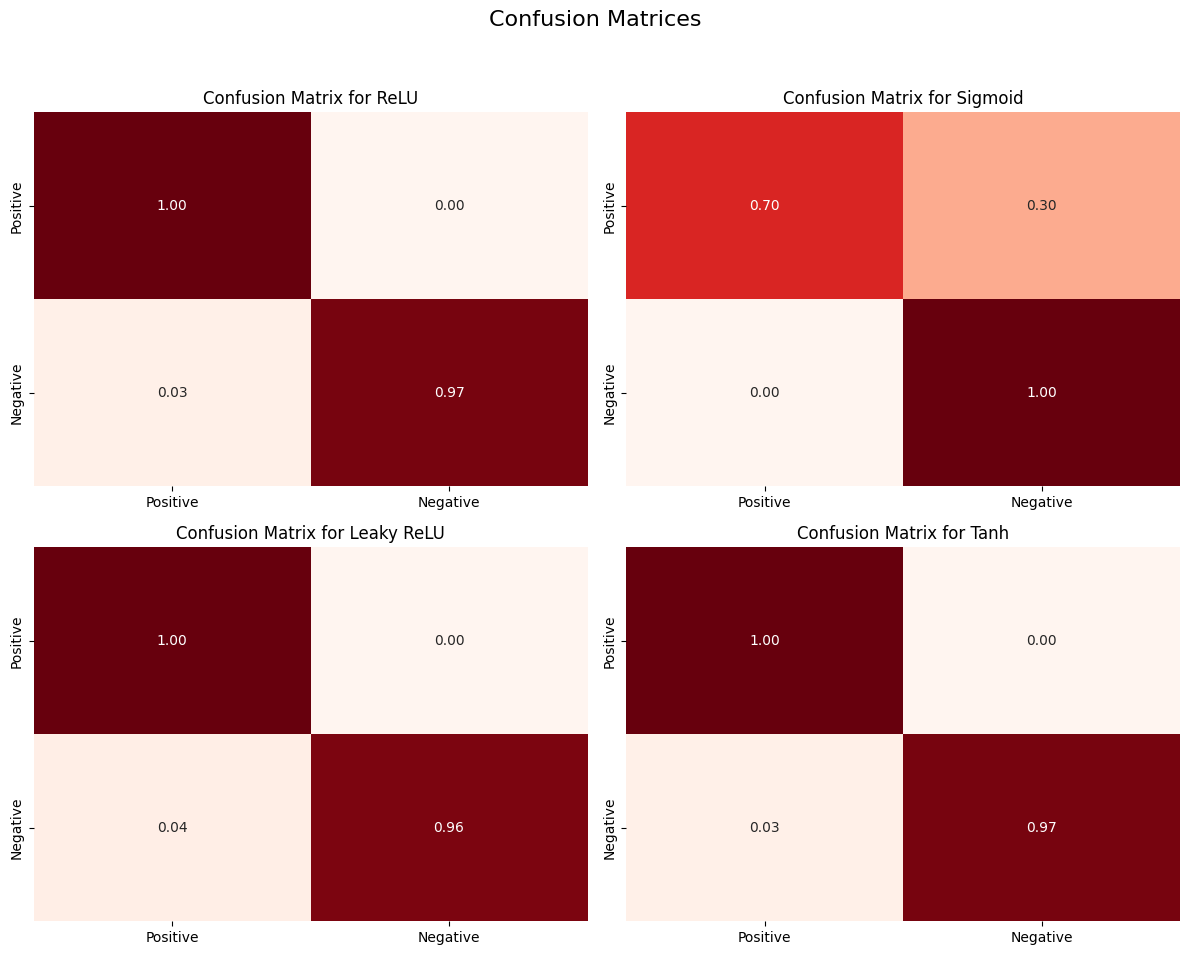

In [9]:
def plot_ROC(X, y, beta, model, method_name, linestyle, ax):
    index = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    # Calculate true and false positive rates
    thresholds = np.linspace(0, 1, 101)
    true_positive_rates = np.array([true_pos_variable_func(model, th)(beta, X, y) for th in thresholds])
    false_positive_rates = np.array([false_pos_variable_func(model, th)(beta, X, y) for th in thresholds])

    # Plot the ROC curve on the provided axis
    ax.plot(false_positive_rates, true_positive_rates, linestyle=linestyle, linewidth=2, label=method_name)
    ax.scatter(false_positive_rates[index], true_positive_rates[index], s=50, zorder=5)

def plot_confusion_matrix(X, y, beta, model, method_name, ax):
    # Calculate the confusion matrix values at threshold 0.5
    tp = true_pos_variable_func(model, 0.5)(beta, X, y)
    fp = false_pos_variable_func(model, 0.5)(beta, X, y)
    confusion_matrix_values = [tp, 1 - tp, fp, 1 - fp]

    # Reshape the list into a 2x2 array and plot the heatmap
    conf_matrix_array = np.array(confusion_matrix_values).reshape((2, 2))
    sns.heatmap(conf_matrix_array, annot=True, fmt='.2f', xticklabels=['Positive', 'Negative'], 
                yticklabels=['Positive', 'Negative'], cmap="Reds", ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for {method_name}')

# Define styles and methods
line_styles = ['-', '--', '-.', '-']
method_names = ["ReLU", "Sigmoid", "Leaky ReLU", "Tanh"]
methods = [nn.relu, nn.sigmoid, nn.leaky_relu, nn.tanh]

# Create a single subplot for ROC curves
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))

# Create a 2x2 subplot grid for confusion matrices
fig_cm, axes_cm = plt.subplots(2, 2, figsize=(12, 10))
axes_cm = axes_cm.flatten()  # Flatten the axes array for easy iteration

result = {}

# Generate plots for each method
for i, method in enumerate(methods):
    result = single_run(X, y, 8e-4, 0.0001, hidden_layer_num=2, node_per_hidden=8, hidden_activation=method, test_index=result.get("test_index"))
    
    # Plot ROC curve on the same subplot
    plot_ROC(result["X_test"], result["y_test"], result["beta_final"], result["model"], method_names[i], line_styles[i], ax_roc)
    
    # Plot confusion matrix on separate subplots
    plot_confusion_matrix(result["X_test"], result["y_test"], result["beta_final"], result["model"], method_names[i], axes_cm[i])

# Finalize and show ROC curves
ax_roc.set_xlabel("False positive rate", fontsize=14)
ax_roc.set_ylabel("True positive rate", fontsize=14)
ax_roc.set_title('ROC Curves', fontsize=16)
ax_roc.legend(loc='lower right', fontsize=12)
fig_roc.tight_layout()
fig_roc.show()

# Finalize and show confusion matrices
fig_cm.suptitle('Confusion Matrices', fontsize=16)
fig_cm.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the suptitle
fig_cm.show()


### Learning rate and numer of hidden layers

Learning rate: 1e-06, Hidden Layer number: 1
Learning rate: 1e-06, Hidden Layer number: 2
Learning rate: 1e-06, Hidden Layer number: 3
Learning rate: 1e-06, Hidden Layer number: 4
Learning rate: 1e-06, Hidden Layer number: 5
Learning rate: 1e-06, Hidden Layer number: 6
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 1
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 2
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 3
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 4
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 5
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 6
Learning rate: 0.000630957344480193, Hidden Layer number: 1
Learning rate: 0.000630957344480193, Hidden Layer number: 2
Learning rate: 0.000630957344480193, Hidden Layer number: 3
Learning rate: 0.000630957344480193, Hidden Layer number: 4
Learning rate: 0.000630957344480193, Hidden Layer number: 5
Learning rate: 0.000630957344480193, Hidden Layer number: 

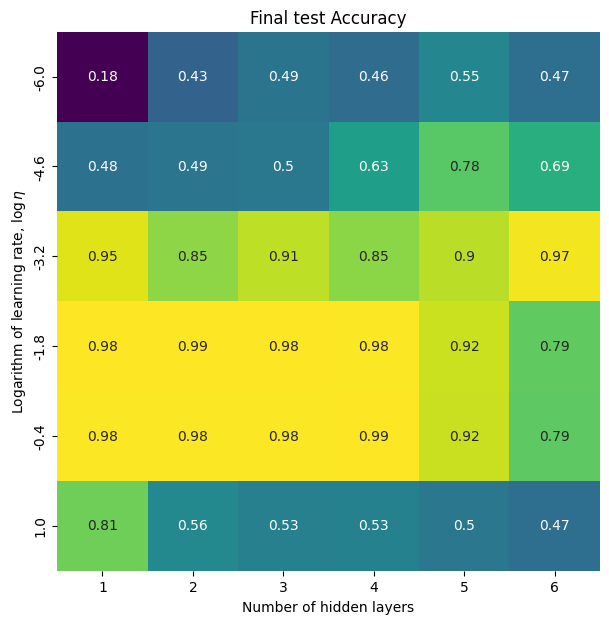

In [11]:
def learning_rate_hidden_layer_grid(plot_or_not=False):
    hidden_layer_numbers = np.arange(1, 7)
    lrs = np.logspace(-6, 1, 6)

    test_errs_all = np.zeros(shape=(6, 6))
    train_errs_all = np.zeros(shape=(6, 6))

    result = {}
    
    for i, lr in enumerate(lrs):
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
            tqdm.write(f"Learning rate: {lr}, Hidden Layer number: {hidden_layer_number}")
            s_test = 0.0
            s_train = 0.0
            for k in range(5):
                result = single_run(X, y, lr=lr, lam=0.01, hidden_layer_num=hidden_layer_number, node_per_hidden=5, hidden_activation=nn.leaky_relu, test_index=result.get("test_index"))
                s_test += result["test_loss_list"][1][-1]
                s_train += result["train_loss_list"][1][-1]

            test_errs_all[i, j] = s_test/5
            train_errs_all[i, j] = s_train/5


    # Make sns heatmap
    fig, ax = plt.subplots(figsize = (7, 7))
    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", cbar=False)

    # Title
    ax.set_title("Final test Accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Logarithm of learning rate, $\log{\eta}$")

    ax.set_yticklabels(np.round(np.log10(lrs), 2))
    ax.set_xticklabels((hidden_layer_numbers))

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}


r= learning_rate_hidden_layer_grid()